In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from pandas.core import datetools
from pandas import Series, DataFrame

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

from arch import arch_model

from scipy.stats import spearmanr,ttest_ind
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\Acer\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  
C:\Users\Acer\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# LSTM

In [3]:
df=pd.read_csv('Boeing_daily.csv')
print(len(df))
df.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
df['Date']=pd.to_datetime(df["Date"])
#df=df.set_index(df.Date)
#df=df.drop("Date",axis=1)

2515


In [19]:
#using_all_data_before_1
end_date ='2018-10-28'
test_start='2018-10-29'
test_end='2019-03-10'

In [20]:
Train=df[df.Date<=end_date]
Test=df[(df.Date>=test_start) & (df.Date<test_end)]

In [21]:
train=Train.iloc[:, 1:2].values
test=Test.iloc[:, 1:2].values

In [22]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [23]:
print("Train:",len(train))
print('test:',len(test))
print('test_size:',len(test)*100/(len(train)+len(test)))

Train: 2391
test: 89
test_size: 3.588709677419355


In [24]:
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [30]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)


Epoch 1/30
2331/2331 [==============================] - 52s 22ms/step - loss: 0.0153
Epoch 2/30
2331/2331 [==============================] - 40s 17ms/step - loss: 0.0019
Epoch 3/30
2331/2331 [==============================] - 38s 16ms/step - loss: 0.0020
Epoch 4/30
2331/2331 [==============================] - 39s 17ms/step - loss: 0.0018
Epoch 5/30
2331/2331 [==============================] - 43s 19ms/step - loss: 0.0017
Epoch 6/30
2331/2331 [==============================] - 44s 19ms/step - loss: 0.0015
Epoch 7/30
2331/2331 [==============================] - 44s 19ms/step - loss: 0.0013
Epoch 8/30
2331/2331 [==============================] - 45s 19ms/step - loss: 0.0013
Epoch 9/30
2331/2331 [==============================] - 43s 18ms/step - loss: 0.0012
Epoch 10/30
2331/2331 [==============================] - 43s 19ms/step - loss: 0.0014
Epoch 11/30
2331/2331 [==============================] - 44s 19ms/step - loss: 0.0012
Epoch 12/30
2331/2331 [==============================] - 45s 19

In [93]:
#prediction using actual test info
dataset_total = pd.concat((Train['Open'], Test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(Test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(test)+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [98]:
#prediction for first observation
dataset_total = Train['Open']
inputs = dataset_total[len(dataset_total)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
pred=[]
X_test = []
X_test.append(inputs[:, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_1 = regressor.predict(X_test)
predicted_stock_price_1 = sc.inverse_transform(predicted_stock_price_1)
pred.append(predicted_stock_price_1[0][0])
pred

(1, 60)


[351.4253]

In [99]:
#prediction using prediction
dataset_total = Train['Open']
inputs = dataset_total[len(dataset_total)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
X_test.append(inputs[:, 0])
X_test = np.array(X_test)
for i in range(0,len(test)):
    X_test=np.delete(X_test,0)
    X_test=X_test.reshape(1,59)
    X_test=np.append(X_test,pred[-1])
    X_test=X_test.reshape(1,60)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price_2 = regressor.predict(X_test)
    predicted_stock_price_2 = sc.inverse_transform(predicted_stock_price_2)
    pred.append(predicted_stock_price_2[0][0])

In [100]:
pred

[351.4253,
 369.60242,
 391.541,
 403.8469,
 409.7407,
 412.7959,
 413.9224,
 414.22095,
 414.1473,
 413.93698,
 413.69794,
 413.47592,
 413.28656,
 413.13156,
 413.0074,
 412.90875,
 412.8305,
 412.7681,
 412.71793,
 412.6772,
 412.64362,
 412.61563,
 412.5919,
 412.57153,
 412.5539,
 412.53836,
 412.52466,
 412.5122,
 412.501,
 412.49072,
 412.48126,
 412.47244,
 412.46417,
 412.45624,
 412.44858,
 412.441,
 412.43356,
 412.42603,
 412.4184,
 412.41046,
 412.4022,
 412.3934,
 412.3841,
 412.3741,
 412.36377,
 412.35345,
 412.3436,
 412.33463,
 412.32733,
 412.32272,
 412.3218,
 412.326,
 412.33707,
 412.3578,
 412.3903,
 412.43707,
 412.502,
 412.58676,
 412.7041,
 412.85196,
 413.04144,
 413.04178,
 413.04196,
 413.04193,
 413.0421,
 413.0421,
 413.04202,
 413.04202,
 413.04202,
 413.04193,
 413.04184,
 413.04184,
 413.04178,
 413.0418,
 413.04178,
 413.04172,
 413.0417,
 413.0417,
 413.0416,
 413.0417,
 413.04163,
 413.0416,
 413.0416,
 413.0416,
 413.0415,
 413.0415,
 413.04156,
 

In [32]:
len(X_test)

89

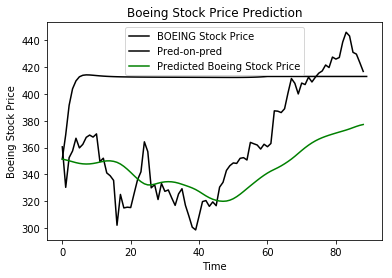

In [101]:
#plt.plot(train, color = 'black', label = 'BOEING Stock Price')
plt.plot(test, color = 'black', label = 'BOEING Stock Price')
plt.plot(pd.Series(pred), color = 'black', label = 'Pred-on-pred')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Boeing Stock Price')
plt.title('Boeing Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.show()